In [7]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
import src.util as util
import yaml
import copy
from tqdm import tqdm
import os
from datetime import datetime
import openpyxl
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from collections import defaultdict

In [8]:
config_data=util.config_load()

In [9]:
df_simil_in=util.pickle_load(config_data['raw_dataset_path_data_simil'])

In [10]:
df_simil_in.columns

Index(['Provider', 'BeneID', 'Is_admit', 'ClmAdmitDiagnosisCode',
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3'],
      dtype='object')

In [11]:
df_simil_diag_count=df_simil_in.copy()

In [12]:
def pad_code(code):
    if pd.isna(code):
        return code  # Keep NaN as is
    return str(code).zfill(4)  # Pad with zeros to make it 4 characters



In [13]:
for i in [ 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3']:
    df_simil_in[i].astype(str)
    df_simil_in[i].replace(r'\.0$', '', regex=True,inplace=True)
    df_simil_in[i].replace(r'nan', np.nan, regex=True,inplace=True)
    df_simil_in[i]=df_simil_in[i].apply(pad_code)

/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_22352/1800943709.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_simil_in[i].replace(r'\.0$', '', regex=True,inplace=True)
/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_22352/1800943709.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [19]:
def ICD_count_matrix(df):
    df_group_data_diag_simil=pd.DataFrame(df['Provider'].unique(),columns=['Provider'])
    for i in [
        'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
        'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
        'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
        'ClmDiagnosisCode_10']:
        pivot_data = df[['Provider',i]].pivot_table(
        index='Provider',                      # Set 'Provider' as the index
        columns=[i],      # Set diagnosis codes as columns
        values=[i],       # Values to aggregate
        aggfunc={i:'count'},                       # Count occurrences
        fill_value=0                           # Fill missing values with 0
    ).reset_index() 
        pivot_data.columns = ['_'.join(map(str, col)) for col in pivot_data.columns.values]
        pivot_data.rename(columns={'Provider_':'Provider'},inplace=True)
        df_group_data_diag_simil=df_group_data_diag_simil.merge(pivot_data,on='Provider',how='left')
    df_group_data_diag_simil.columns = df_group_data_diag_simil.columns.str.split('_').str[-1]
    df_group_data_diag_simil=df_group_data_diag_simil.T.groupby(df_group_data_diag_simil.columns).sum()
    df_group_data_diag_simil=df_group_data_diag_simil.T
    data_reordered=df_group_data_diag_simil.drop(columns='Provider').copy()
    return data_reordered,df_group_data_diag_simil

In [20]:
data_reordered,df_group_data_diag_simil=ICD_count_matrix(df_simil_in)
data_reordered=data_reordered.astype(int)

In [21]:

from collections import defaultdict
# Sample DataFrame structure (you would replace this with your actual DataFrame)


df = df_simil_in[['Provider','BeneID',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10']]

# Step 1: Create a mapping from ICD codes to sets of providers
icd_to_providers = defaultdict(set)

# Combine diagnosis code columns and fill the mapping
diagnosis_columns = [f'ClmDiagnosisCode_{i}' for i in range(1, 11)]

for _, row in df.iterrows():
    Provider=row['Provider']
    for col in diagnosis_columns:
        icd_code = row[col]
        if pd.notna(icd_code):  # Check if the ICD code is not NaN
            icd_to_providers[icd_code].add(Provider)

# Step 2: Get unique ICD codes
icd_codes = list(icd_to_providers.keys())
m = len(icd_codes)

# Step 3: Initialize the Jaccard similarity matrix
jaccard_matrix = np.zeros((m, m))

# Function to calculate Jaccard similarity
def jaccard_similarity(set_a, set_b):
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union if union != 0 else 0

# Step 4: Populate the Jaccard similarity matrix
for i in range(m):
    for j in range(m):
        if i == j:
            jaccard_matrix[i, j] = 1  # Jaccard similarity with itself is 1
        elif j > i:  # Calculate only for upper triangle to avoid redundancy
            similarity = jaccard_similarity(icd_to_providers[icd_codes[i]], icd_to_providers[icd_codes[j]])
            jaccard_matrix[i, j] = similarity
            jaccard_matrix[j, i] = similarity  # Symmetric matrix

# Step 5: Create a DataFrame for the Jaccard similarity matrix
jaccard_df = pd.DataFrame(jaccard_matrix, index=icd_codes, columns=icd_codes)


In [22]:
jaccard_df = jaccard_df[data_reordered.columns]
jaccard_df=round(jaccard_df,2)
jaccard_df_rearranged = jaccard_df.reindex(data_reordered.columns)

In [23]:
data_reordered=data_reordered.astype(int)

In [26]:
data= data_reordered.dot(jaccard_df_rearranged.values)

In [27]:
data.columns=data_reordered.columns

In [28]:
util.pickle_dump(df_group_data_diag_simil['Provider'],config_data['raw_dataset_provider_data'])
util.pickle_dump(data_reordered,config_data['raw_dataset_path_usage'])
util.pickle_dump(jaccard_df_rearranged,config_data['raw_dataset_path_simil_sub'])

In [29]:
df_similarity=util.pickle_load(config_data['raw_dataset_path_simil_sub'])
df_icd_count_matrix=util.pickle_load(config_data['raw_dataset_path_usage'])
data=util.pickle_load(config_data["raw_dataset_path_data_matrix"])

In [30]:
data

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8801,V8802,V8803,V8901,V8902,V8903,V8904,V8905,V8909,Provider
0,10.55,3.79,10.39,2.80,22.00,0.45,2.73,43.47,37.96,74.69,...,688.41,108.22,109.12,67.84,72.61,71.82,110.72,89.62,70.78,PRV57172
1,4.56,1.47,4.27,1.18,8.75,0.52,1.02,9.22,14.85,30.04,...,266.35,42.79,42.52,26.08,29.17,28.07,46.07,30.61,27.21,PRV55158
2,10.12,3.90,9.45,2.54,19.47,0.47,2.32,20.27,32.64,66.49,...,609.99,97.27,98.85,61.56,65.86,65.08,88.83,69.65,63.32,PRV54966
3,0.51,0.24,0.53,0.11,0.97,0.03,0.22,1.04,1.98,3.57,...,31.26,5.19,5.44,3.37,3.44,3.43,4.58,3.52,3.33,PRV54890
4,1.40,0.66,1.44,0.36,2.48,0.06,0.37,3.10,4.55,9.41,...,81.94,13.38,13.29,8.40,9.26,8.46,12.31,9.55,8.88,PRV52145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.01,0.00,0.01,0.02,0.01,0.00,0.00,0.02,0.11,0.13,...,1.19,0.16,0.15,0.09,0.10,0.09,0.14,0.15,0.11,PRV54294
5406,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.08,0.09,...,1.38,0.14,0.12,0.09,0.09,0.09,0.12,0.09,0.10,PRV51053
5407,0.06,0.04,0.06,0.01,0.09,0.00,0.01,0.09,0.10,0.37,...,2.71,0.46,0.49,0.27,0.32,0.32,0.43,0.35,0.24,PRV55405
5408,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.09,0.03,0.03,0.01,0.01,0.01,0.03,0.01,0.01,PRV57061


In [31]:
data

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8801,V8802,V8803,V8901,V8902,V8903,V8904,V8905,V8909,Provider
0,10.55,3.79,10.39,2.80,22.00,0.45,2.73,43.47,37.96,74.69,...,688.41,108.22,109.12,67.84,72.61,71.82,110.72,89.62,70.78,PRV57172
1,4.56,1.47,4.27,1.18,8.75,0.52,1.02,9.22,14.85,30.04,...,266.35,42.79,42.52,26.08,29.17,28.07,46.07,30.61,27.21,PRV55158
2,10.12,3.90,9.45,2.54,19.47,0.47,2.32,20.27,32.64,66.49,...,609.99,97.27,98.85,61.56,65.86,65.08,88.83,69.65,63.32,PRV54966
3,0.51,0.24,0.53,0.11,0.97,0.03,0.22,1.04,1.98,3.57,...,31.26,5.19,5.44,3.37,3.44,3.43,4.58,3.52,3.33,PRV54890
4,1.40,0.66,1.44,0.36,2.48,0.06,0.37,3.10,4.55,9.41,...,81.94,13.38,13.29,8.40,9.26,8.46,12.31,9.55,8.88,PRV52145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.01,0.00,0.01,0.02,0.01,0.00,0.00,0.02,0.11,0.13,...,1.19,0.16,0.15,0.09,0.10,0.09,0.14,0.15,0.11,PRV54294
5406,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.08,0.09,...,1.38,0.14,0.12,0.09,0.09,0.09,0.12,0.09,0.10,PRV51053
5407,0.06,0.04,0.06,0.01,0.09,0.00,0.01,0.09,0.10,0.37,...,2.71,0.46,0.49,0.27,0.32,0.32,0.43,0.35,0.24,PRV55405
5408,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.09,0.03,0.03,0.01,0.01,0.01,0.03,0.01,0.01,PRV57061


In [32]:
data.fillna(0,inplace=True)

In [33]:

scaler=RobustScaler()
scaled_data_level1=scaler.fit_transform(data.drop(columns=['Provider']))


In [34]:
scaled_data_level1 = pd.DataFrame(scaled_data_level1, columns=data.drop(columns=['Provider']).columns)

In [35]:
# Fit Isolation Forest
model = IsolationForest(contamination=0.1,n_estimators=100,max_features=5)  # Adjust contamination rate as needed
model.fit(scaled_data_level1)

anomaly_scores = model.decision_function(scaled_data_level1)
# Predict anomalies
anomalies = model.predict(scaled_data_level1)

# -1 for anomaly, 1 for normal
anomaly_indices = np.where(anomalies == -1)[0]
anomalous_data = scaled_data_level1.iloc[anomaly_indices]
anomalous_data_actual = scaled_data_level1.iloc[anomaly_indices]
scaled_data_level1['Anomaly_ind']=anomalies
data['Anomaly_ind']=anomalies
data['Anomaly_score']=anomaly_scores
scaled_data_level1['Anomaly_score']=anomaly_scores

In [36]:
data

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8803,V8901,V8902,V8903,V8904,V8905,V8909,Provider,Anomaly_ind,Anomaly_score
0,10.55,3.79,10.39,2.80,22.00,0.45,2.73,43.47,37.96,74.69,...,109.12,67.84,72.61,71.82,110.72,89.62,70.78,PRV57172,-1,-0.282728
1,4.56,1.47,4.27,1.18,8.75,0.52,1.02,9.22,14.85,30.04,...,42.52,26.08,29.17,28.07,46.07,30.61,27.21,PRV55158,-1,-0.150948
2,10.12,3.90,9.45,2.54,19.47,0.47,2.32,20.27,32.64,66.49,...,98.85,61.56,65.86,65.08,88.83,69.65,63.32,PRV54966,-1,-0.275666
3,0.51,0.24,0.53,0.11,0.97,0.03,0.22,1.04,1.98,3.57,...,5.44,3.37,3.44,3.43,4.58,3.52,3.33,PRV54890,1,0.093628
4,1.40,0.66,1.44,0.36,2.48,0.06,0.37,3.10,4.55,9.41,...,13.29,8.40,9.26,8.46,12.31,9.55,8.88,PRV52145,1,0.012400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.01,0.00,0.01,0.02,0.01,0.00,0.00,0.02,0.11,0.13,...,0.15,0.09,0.10,0.09,0.14,0.15,0.11,PRV54294,1,0.146466
5406,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.08,0.09,...,0.12,0.09,0.09,0.09,0.12,0.09,0.10,PRV51053,1,0.137793
5407,0.06,0.04,0.06,0.01,0.09,0.00,0.01,0.09,0.10,0.37,...,0.49,0.27,0.32,0.32,0.43,0.35,0.24,PRV55405,1,0.148974
5408,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.03,0.01,0.01,0.01,0.03,0.01,0.01,PRV57061,1,0.094415


In [37]:
data_with_anom=util.pickle_dump(data,config_data["raw_dataset_path_data_matrix"])

In [38]:
X=scaled_data_level1.drop(columns='Anomaly_ind')
y=scaled_data_level1['Anomaly_ind']

In [39]:
scaled_data_level1

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8802,V8803,V8901,V8902,V8903,V8904,V8905,V8909,Anomaly_ind,Anomaly_score
0,20.72,20.722222,21.723404,18.333333,21.823232,14.666667,20.615385,43.505051,20.833566,21.561765,...,21.458586,21.351944,21.637693,21.396396,21.425532,23.928571,24.912429,21.306748,-1,-0.282728
1,8.74,7.833333,8.702128,7.533333,8.439394,17.000000,7.461538,8.909091,7.904895,8.429412,...,8.240404,8.071785,8.068237,8.351351,8.127660,9.719780,8.242938,7.941718,-1,-0.150948
2,19.86,21.333333,19.723404,16.600000,19.267677,15.333333,17.461538,20.070707,17.857343,19.150000,...,19.246465,19.304088,19.597076,19.369369,19.376900,19.117582,19.271186,19.018405,-1,-0.275666
3,0.64,1.000000,0.744681,0.400000,0.580808,0.666667,1.307692,0.646465,0.704895,0.644118,...,0.644444,0.677966,0.688871,0.624625,0.638298,0.601099,0.590395,0.616564,1,0.093628
4,2.42,3.333333,2.680851,2.066667,2.106061,1.666667,2.461538,2.727273,2.142657,2.361765,...,2.298990,2.243270,2.323314,2.372372,2.167173,2.300000,2.293785,2.319018,1,0.012400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,-0.36,-0.333333,-0.361702,-0.200000,-0.388889,-0.333333,-0.384615,-0.383838,-0.341259,-0.367647,...,-0.371717,-0.376869,-0.376929,-0.378378,-0.376900,-0.374725,-0.361582,-0.371166,1,0.146466
5406,-0.38,-0.333333,-0.382979,-0.333333,-0.378788,-0.333333,-0.384615,-0.393939,-0.358042,-0.379412,...,-0.375758,-0.382851,-0.376929,-0.381381,-0.376900,-0.379121,-0.378531,-0.374233,1,0.137793
5407,-0.26,-0.111111,-0.255319,-0.266667,-0.308081,-0.333333,-0.307692,-0.313131,-0.346853,-0.297059,...,-0.311111,-0.309073,-0.318440,-0.312312,-0.306991,-0.310989,-0.305085,-0.331288,1,0.148974
5408,-0.38,-0.333333,-0.382979,-0.333333,-0.398990,-0.333333,-0.384615,-0.404040,-0.402797,-0.405882,...,-0.397980,-0.400798,-0.402924,-0.405405,-0.401216,-0.398901,-0.401130,-0.401840,1,0.094415


/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


1.4671223163604736


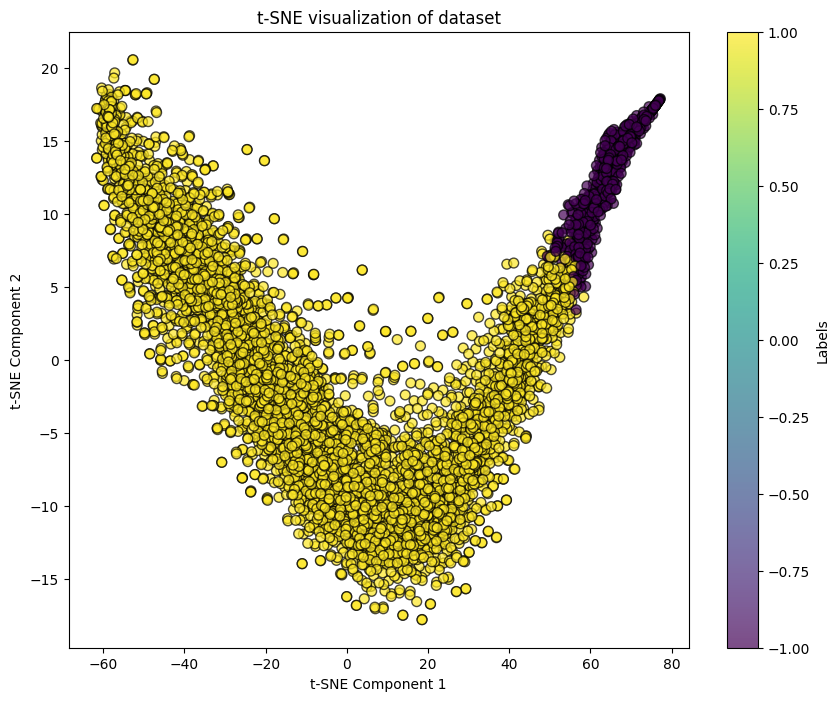

In [40]:
from sklearn.manifold import TSNE
# Create a t-SNE instance and fit_transform the data
tsne = TSNE(n_components=2, random_state=42, perplexity=55, n_iter=5000)
# X_tsne = tsne.fit_transform(df_simil_in.drop(columns=['Provider', 'Is_admit', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
#        'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
#        'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
#        'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
#        'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
#        'ClmProcedureCode_3']))

X_tsne = tsne.fit_transform(X)
print(tsne.kl_divergence_)

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=y,cmap='viridis', alpha=0.7, edgecolors='k', s=50)

# Add legend and title
plt.title('t-SNE visualization of dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Labels')

plt.show()

In [41]:
data['Anomaly_ind'] = data['Anomaly_score'].apply(lambda x: 1 if x < -0.1 else 0)
scaled_data_level1['Anomaly_ind'] = scaled_data_level1['Anomaly_score'].apply(lambda x: 1 if x <-0.1 else 0)

In [42]:
dataset_anom=data[data.Anomaly_ind==1]
dataset_normal=data[data.Anomaly_ind==0]
dataset_anom_scale=scaled_data_level1[scaled_data_level1.Anomaly_ind==1]
dataset_normal_scale=scaled_data_level1[scaled_data_level1.Anomaly_ind==0]

In [43]:
dataset_normal

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8803,V8901,V8902,V8903,V8904,V8905,V8909,Provider,Anomaly_ind,Anomaly_score
3,0.51,0.24,0.53,0.11,0.97,0.03,0.22,1.04,1.98,3.57,...,5.44,3.37,3.44,3.43,4.58,3.52,3.33,PRV54890,0,0.093628
4,1.40,0.66,1.44,0.36,2.48,0.06,0.37,3.10,4.55,9.41,...,13.29,8.40,9.26,8.46,12.31,9.55,8.88,PRV52145,0,0.012400
5,2.75,0.97,2.69,0.60,5.49,0.07,0.71,5.34,8.42,18.12,...,25.93,16.01,17.13,17.07,23.35,18.26,16.37,PRV54683,0,-0.053966
7,3.54,1.15,3.82,1.19,7.15,0.17,1.09,7.04,10.63,22.40,...,33.16,20.29,22.42,21.94,30.30,22.57,21.24,PRV55064,0,-0.093907
8,0.25,0.10,0.21,0.06,0.67,0.00,0.07,0.55,0.90,1.79,...,2.82,1.85,1.94,1.82,2.55,1.93,1.83,PRV55104,0,0.115522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.01,0.00,0.01,0.02,0.01,0.00,0.00,0.02,0.11,0.13,...,0.15,0.09,0.10,0.09,0.14,0.15,0.11,PRV54294,0,0.146466
5406,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.01,0.08,0.09,...,0.12,0.09,0.09,0.09,0.12,0.09,0.10,PRV51053,0,0.137793
5407,0.06,0.04,0.06,0.01,0.09,0.00,0.01,0.09,0.10,0.37,...,0.49,0.27,0.32,0.32,0.43,0.35,0.24,PRV55405,0,0.148974
5408,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.03,0.01,0.01,0.01,0.03,0.01,0.01,PRV57061,0,0.094415


In [44]:
clusters=scaled_data_level1['Anomaly_ind'].values

In [45]:
from sklearn.metrics import silhouette_score

score = silhouette_score(scaled_data_level1, clusters)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.8681606379021564


In [46]:
dataset_anom_rank_if_sorted=dataset_anom.sort_values(by='Anomaly_score',ascending=True)


In [47]:
dataset_anom_rank_if_sorted

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8803,V8901,V8902,V8903,V8904,V8905,V8909,Provider,Anomaly_ind,Anomaly_score
21,48.23,17.37,44.84,13.22,94.84,1.96,11.30,161.20,150.89,313.87,...,463.68,286.19,309.46,301.34,448.22,323.09,295.48,PRV51459,1,-0.331621
49,25.79,9.44,25.21,7.01,51.31,1.06,6.40,53.34,82.63,170.29,...,253.79,154.44,167.74,165.70,226.40,176.30,162.41,PRV51574,1,-0.329886
16,28.99,10.03,26.62,8.10,52.60,1.20,7.43,56.78,87.53,178.53,...,265.12,188.18,175.19,171.17,238.25,183.47,167.32,PRV53797,1,-0.329886
352,21.47,7.49,63.15,6.10,42.11,0.78,5.42,42.47,65.52,135.81,...,219.36,122.75,132.59,130.31,179.05,139.75,128.08,PRV53918,1,-0.321839
704,19.27,6.45,18.47,5.30,38.72,1.02,5.14,40.89,62.65,154.56,...,191.95,116.87,145.99,124.95,191.70,133.84,121.18,PRV54895,1,-0.321268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,1.90,0.68,1.76,0.63,5.54,0.10,0.45,4.67,14.63,21.39,...,31.15,18.81,20.76,21.03,28.74,22.64,21.69,PRV51560,1,-0.107041
1285,2.29,0.65,1.91,0.82,6.71,0.05,0.58,5.01,15.85,22.68,...,33.13,20.67,22.75,22.55,30.56,24.56,22.83,PRV51501,1,-0.106701
47,3.01,1.10,2.93,0.77,6.63,0.08,0.56,6.90,13.09,23.64,...,36.14,21.77,23.94,23.48,32.08,25.38,23.29,PRV51539,1,-0.105197
521,3.67,1.44,3.51,0.94,7.17,0.28,1.26,7.49,10.88,22.66,...,34.46,21.06,22.89,22.04,31.30,24.16,21.80,PRV52665,1,-0.100716


In [48]:
dataset_anom_rank_if_sorted['Rank']=range(1,len(dataset_anom_rank_if_sorted)+1)

In [49]:
dataset_anom_rank_if_sorted

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8901,V8902,V8903,V8904,V8905,V8909,Provider,Anomaly_ind,Anomaly_score,Rank
21,48.23,17.37,44.84,13.22,94.84,1.96,11.30,161.20,150.89,313.87,...,286.19,309.46,301.34,448.22,323.09,295.48,PRV51459,1,-0.331621,1
49,25.79,9.44,25.21,7.01,51.31,1.06,6.40,53.34,82.63,170.29,...,154.44,167.74,165.70,226.40,176.30,162.41,PRV51574,1,-0.329886,2
16,28.99,10.03,26.62,8.10,52.60,1.20,7.43,56.78,87.53,178.53,...,188.18,175.19,171.17,238.25,183.47,167.32,PRV53797,1,-0.329886,3
352,21.47,7.49,63.15,6.10,42.11,0.78,5.42,42.47,65.52,135.81,...,122.75,132.59,130.31,179.05,139.75,128.08,PRV53918,1,-0.321839,4
704,19.27,6.45,18.47,5.30,38.72,1.02,5.14,40.89,62.65,154.56,...,116.87,145.99,124.95,191.70,133.84,121.18,PRV54895,1,-0.321268,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,1.90,0.68,1.76,0.63,5.54,0.10,0.45,4.67,14.63,21.39,...,18.81,20.76,21.03,28.74,22.64,21.69,PRV51560,1,-0.107041,168
1285,2.29,0.65,1.91,0.82,6.71,0.05,0.58,5.01,15.85,22.68,...,20.67,22.75,22.55,30.56,24.56,22.83,PRV51501,1,-0.106701,169
47,3.01,1.10,2.93,0.77,6.63,0.08,0.56,6.90,13.09,23.64,...,21.77,23.94,23.48,32.08,25.38,23.29,PRV51539,1,-0.105197,170
521,3.67,1.44,3.51,0.94,7.17,0.28,1.26,7.49,10.88,22.66,...,21.06,22.89,22.04,31.30,24.16,21.80,PRV52665,1,-0.100716,171


In [50]:
data_if_rank=util.pickle_dump(dataset_anom_rank_if_sorted,config_data['raw_dataset_path_if_rank'])

In [51]:
Model_pickled=util.pickle_dump(model,config_data['Isolation_forest_model'])

In [21]:
import shap
explainer=shap.TreeExplainer(model)
shap_values=explainer(data_if_rank.drop(['Provider'],axis=1))
#shap_values_norm=explainer(dataset_normal.drop(columns='Provider'))

In [301]:
dataset_anom[dataset_anom.Provider=='PRV51459']

,79678,71656,64881,36401,2948,31400,42490,11590,72089,4271,...,94225,E8259,90241,0828,E8262,E9192,86131,Provider,Anomaly_ind,Anomaly_score
21,7.78,1.8,0.31,0.18,496.18,2.97,17.75,0.66,7.36,300.31,...,0.22,0.05,0.03,0.0,0.03,0.02,0.11,PRV51459,1,-0.410956


In [302]:
data_test1=dataset_anom.reset_index()

In [303]:
data_test1[data_test1.Provider=='PRV51459']

,index,79678,71656,64881,36401,2948,31400,42490,11590,72089,...,94225,E8259,90241,0828,E8262,E9192,86131,Provider,Anomaly_ind,Anomaly_score
8,21,7.78,1.8,0.31,0.18,496.18,2.97,17.75,0.66,7.36,...,0.22,0.05,0.03,0.0,0.03,0.02,0.11,PRV51459,1,-0.410956


In [304]:
#PRV55158
df_simil_in[df_simil_in.Provider=='PRV55158']

,Provider,BeneID,Is_admit,ClmAdmitDiagnosisCode,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3
2,PRV55158,BENE100001,0,64880,NaN,64881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PRV55158,BENE100001,0,V573,NaN,31400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,PRV55158,BENE100002,0,NaN,NaN,79029,2724,78702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1580,PRV55158,BENE100425,0,NaN,NaN,72293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3017,PRV55158,BENE100799,0,73620,NaN,73811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554182,PRV55158,BENE98935,0,NaN,NaN,42781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
554183,PRV55158,BENE98935,0,NaN,NaN,4271,V5861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
556548,PRV55158,BENE99563,0,9597,NaN,9132,9160,7823,92401,2948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
556743,PRV55158,BENE99607,0,NaN,NaN,82011,V1254,25000,78079,V4364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [305]:
data

,79678,71656,64881,36401,2948,31400,42490,11590,72089,4271,...,94225,E8259,90241,0828,E8262,E9192,86131,Provider,Anomaly_ind,Anomaly_score
0,1.32,1.39,0.08,0.06,118.73,0.67,4.89,0.21,4.73,73.03,...,0.02,0.01,0.02,0.0,0.02,0.00,0.00,PRV57172,1,-0.307017
1,1.12,0.20,1.04,0.11,54.03,1.36,1.32,0.10,0.66,27.14,...,0.04,0.00,0.01,0.0,0.03,0.00,0.01,PRV55158,1,-0.150999
2,0.45,0.29,0.20,1.05,110.16,0.75,5.69,1.10,4.52,62.92,...,0.01,0.00,0.08,0.0,0.00,0.03,0.06,PRV54966,1,-0.293671
3,0.00,0.02,0.01,0.02,6.26,0.08,0.18,0.01,0.05,3.95,...,0.00,0.00,0.00,0.0,0.00,0.00,0.01,PRV54890,0,0.085190
4,0.03,0.07,0.02,0.00,14.83,0.14,0.31,0.02,0.19,10.17,...,0.02,0.00,0.00,0.0,0.00,0.00,0.00,PRV52145,0,0.001028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.08,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,PRV54294,0,0.139884
5406,0.00,0.00,0.00,0.00,0.30,0.00,0.04,0.00,0.00,0.19,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,PRV51053,0,0.143890
5407,0.00,0.00,0.00,0.00,0.35,0.00,0.02,0.00,0.00,0.18,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,PRV55405,0,0.140048
5408,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.02,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,PRV57061,0,0.142545


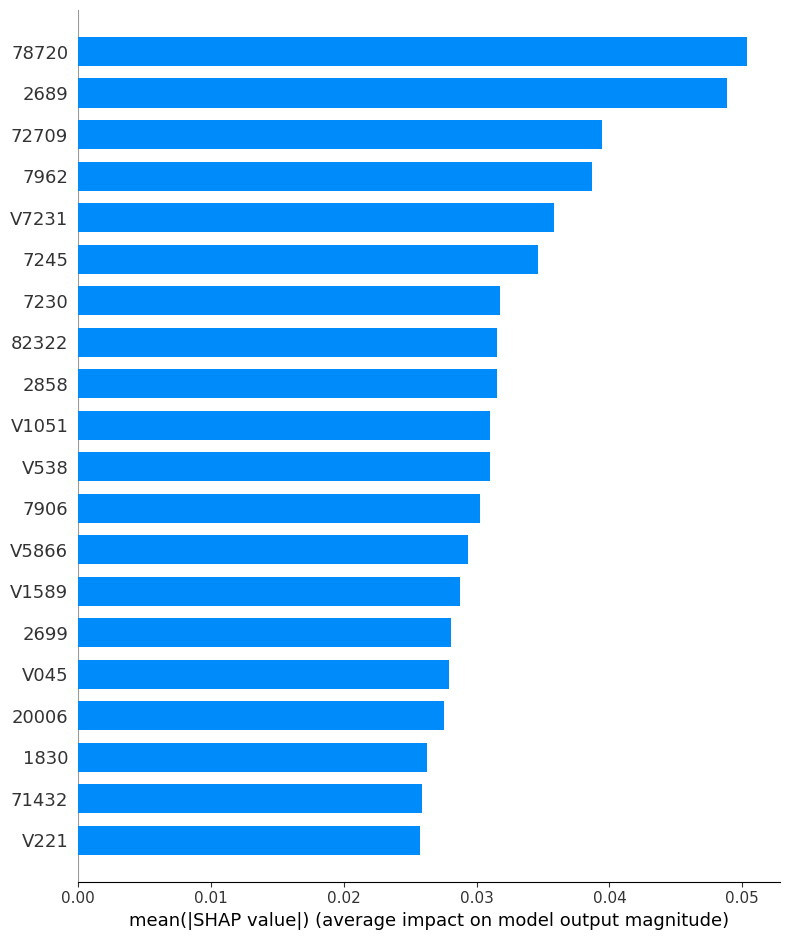

In [22]:
shap.summary_plot(shap_values, plot_type='bar')

In [141]:
type(shap_values[0])

shap._explanation.Explanation

In [23]:
values=shap_values[0].values
feature_importance = pd.DataFrame(list(zip(dataset_anom.columns,values)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=True,inplace=True)
feature_importance

,col_name,feature_importance_vals
1150,7245,-0.090381
1570,30500,-0.082543
2098,1830,-0.071804
1092,V1051,-0.066643
549,7962,-0.066601
...,...,...
8019,64870,0.024641
9632,80446,0.025760
3483,V045,0.027923
3727,V1589,0.030805


In [308]:
data['4019']

0       469.94
1       174.99
2       441.15
3        25.18
4        61.64
         ...  
5405      0.28
5406      0.42
5407      0.70
5408      1.00
5409      1.05
Name: 4019, Length: 5410, dtype: float64

In [29]:
dataset_normal.reset_index()

,index,79678,71656,64881,36401,2948,31400,42490,11590,72089,...,94225,E8259,90241,0828,E8262,E9192,86131,Provider,Anomaly_ind,Anomaly_score
0,3,0.268828,0.158708,0.026111,0.032804,6.396052,0.274141,0.637388,0.052084,0.465142,...,0.002184,0.005360,0.002987,0.002221,0.003067,0.002306,0.007251,PRV54890,0,0.076955
1,4,0.749451,0.397005,0.053974,0.017319,15.156514,0.676720,1.639770,0.128579,1.264143,...,0.028501,0.016125,0.008641,0.006594,0.001926,0.001805,0.005708,PRV52145,0,0.016984
2,5,1.402459,0.733880,0.127180,0.080365,28.226194,1.209734,3.087388,0.274412,3.470952,...,0.025299,0.032537,0.008559,0.013648,0.005433,0.005514,0.012517,PRV54683,0,-0.061164
3,8,0.151868,0.084398,0.004697,0.003733,3.191933,0.131536,0.369905,0.026324,0.253059,...,0.000531,0.004003,0.000936,0.000903,0.000286,0.000161,0.000886,PRV55104,0,0.129719
4,9,0.137490,0.058992,0.006527,0.002476,3.015653,0.101270,0.340345,0.026051,0.210683,...,0.002459,0.001646,0.000099,0.000423,0.002011,0.001586,0.002002,PRV55006,0,0.128280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5192,5405,0.005462,0.003058,0.000072,0.000000,0.171112,0.010825,0.022083,0.000287,0.014029,...,0.000758,0.000591,0.000000,0.000000,0.000000,0.000000,0.000000,PRV54294,0,0.134793
5193,5406,0.007681,0.004730,0.000152,0.000076,0.306833,0.011161,0.037927,0.001949,0.016295,...,0.000000,0.000076,0.000366,0.000218,0.000000,0.000000,0.000322,PRV51053,0,0.138800
5194,5407,0.019504,0.008462,0.000610,0.002095,0.355129,0.017781,0.048779,0.003507,0.041997,...,0.000000,0.000079,0.000000,0.000000,0.000058,0.000000,0.000357,PRV55405,0,0.141123
5195,5408,0.001716,0.000555,0.000072,0.000072,0.054048,0.001003,0.002968,0.000125,0.002485,...,0.000000,0.000018,0.000000,0.000018,0.000000,0.000018,0.000000,PRV57061,0,0.127285


In [36]:
dataset_normal=dataset_normal.reset_index(drop=True)
dataset_normal.loc[4]

79678             0.13749
71656            0.058992
64881            0.006527
36401            0.002476
2948             3.015653
                   ...   
E9192            0.001586
86131            0.002002
Provider         PRV55006
Anomaly_ind             0
Anomaly_score     0.12828
Name: 4, Length: 11017, dtype: object

In [35]:
dataset_normal

,79678,71656,64881,36401,2948,31400,42490,11590,72089,4271,...,94225,E8259,90241,0828,E8262,E9192,86131,Provider,Anomaly_ind,Anomaly_score
0,0.268828,0.158708,0.026111,0.032804,6.396052,0.274141,0.637388,0.052084,0.465142,4.118501,...,0.002184,0.005360,0.002987,0.002221,0.003067,0.002306,0.007251,PRV54890,0,0.076955
1,0.749451,0.397005,0.053974,0.017319,15.156514,0.676720,1.639770,0.128579,1.264143,10.519411,...,0.028501,0.016125,0.008641,0.006594,0.001926,0.001805,0.005708,PRV52145,0,0.016984
2,1.402459,0.733880,0.127180,0.080365,28.226194,1.209734,3.087388,0.274412,3.470952,15.410737,...,0.025299,0.032537,0.008559,0.013648,0.005433,0.005514,0.012517,PRV54683,0,-0.061164
3,0.151868,0.084398,0.004697,0.003733,3.191933,0.131536,0.369905,0.026324,0.253059,1.904960,...,0.000531,0.004003,0.000936,0.000903,0.000286,0.000161,0.000886,PRV55104,0,0.129719
4,0.137490,0.058992,0.006527,0.002476,3.015653,0.101270,0.340345,0.026051,0.210683,2.820152,...,0.002459,0.001646,0.000099,0.000423,0.002011,0.001586,0.002002,PRV55006,0,0.128280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5192,0.005462,0.003058,0.000072,0.000000,0.171112,0.010825,0.022083,0.000287,0.014029,0.093396,...,0.000758,0.000591,0.000000,0.000000,0.000000,0.000000,0.000000,PRV54294,0,0.134793
5193,0.007681,0.004730,0.000152,0.000076,0.306833,0.011161,0.037927,0.001949,0.016295,0.200387,...,0.000000,0.000076,0.000366,0.000218,0.000000,0.000000,0.000322,PRV51053,0,0.138800
5194,0.019504,0.008462,0.000610,0.002095,0.355129,0.017781,0.048779,0.003507,0.041997,0.212563,...,0.000000,0.000079,0.000000,0.000000,0.000058,0.000000,0.000357,PRV55405,0,0.141123
5195,0.001716,0.000555,0.000072,0.000072,0.054048,0.001003,0.002968,0.000125,0.002485,0.023818,...,0.000000,0.000018,0.000000,0.000018,0.000000,0.000018,0.000000,PRV57061,0,0.127285


In [265]:
scaled_data_level1

,79678,71656,64881,36401,2948,31400,42490,11590,72089,4271,...,3203,94225,E8259,90241,0828,E8262,E9192,86131,Anomaly_ind,Anomaly_score
0,23.325610,27.207967,21.621721,21.801005,18.854885,20.044603,20.604983,21.089665,25.914125,20.197701,...,22.776112,18.253957,22.336579,27.798374,16.815724,32.892591,21.281961,16.898330,1,-0.300835
1,10.985737,8.165665,68.572784,18.023444,8.321965,11.699564,7.281141,8.359801,7.566015,7.217591,...,6.152898,14.072712,6.942318,10.330318,5.439200,25.396295,8.118521,12.360870,1,-0.134858
2,18.792178,18.109050,26.917390,126.210766,17.413446,18.191695,20.845001,35.513354,24.244394,17.367712,...,15.910417,11.332613,14.711505,56.852390,20.716707,26.597152,36.534628,33.999071,1,-0.277883
3,0.543605,0.631482,1.251866,3.175684,0.613217,0.695068,0.535453,0.522233,0.532744,0.722246,...,0.292626,0.220200,0.639823,1.383653,0.315676,2.013910,1.598232,2.394631,0,0.078848
4,2.186184,2.189342,2.953814,1.529187,1.999178,2.314661,1.979665,1.854450,2.119924,2.471521,...,3.712564,5.890911,2.630668,4.574548,1.514729,1.188328,1.227915,1.817050,0,0.011744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,-0.366794,-0.383905,-0.338681,-0.312340,-0.371884,-0.364475,-0.350305,-0.379834,-0.362853,-0.377869,...,-0.307149,-0.086956,-0.242077,-0.302070,-0.293345,-0.206450,-0.105934,-0.319496,0,0.146567
5406,-0.359243,-0.372164,-0.333805,-0.304271,-0.350427,-0.363198,-0.327598,-0.350890,-0.358121,-0.348608,...,-0.293077,-0.250231,-0.337341,-0.095578,-0.233694,-0.206450,-0.105934,-0.198991,0,0.154020
5407,-0.318601,-0.348648,-0.305841,-0.089605,-0.342780,-0.336478,-0.312119,-0.323757,-0.307324,-0.345296,...,-0.292289,-0.250231,-0.336842,-0.302070,-0.293345,-0.164393,-0.105934,-0.185774,0,0.150277
5408,-0.379644,-0.400228,-0.338699,-0.304719,-0.390419,-0.403991,-0.378091,-0.382657,-0.385768,-0.396878,...,-0.326363,-0.250231,-0.348066,-0.302070,-0.288432,-0.206450,-0.092693,-0.319496,0,0.133480


In [5]:
from pyod.models.sod import SOD
from pyod.utils.data import generate_data

#Local outlier Factor

In [20]:
from sklearn.neighbors import LocalOutlierFactor


# Fit LOF
lof = LocalOutlierFactor(n_neighbors=500,contamination=0.1)
anomalies = lof.fit_predict(scaled_data_level1.iloc[:, 0:10981])
lof_scores = lof.negative_outlier_factor_  
lof_scores = lof_scores.reshape(-1, 1)  # Reshape for compatibility

# Identify anomalies (Anomalies labeled as -1)
scaled_data_level1['Anomaly_lof']=anomalies
data['Anomaly_lof']=anomalies
scaled_data_level1['Anomaly_score_lof']=lof_scores
data['Anomaly_score_lof']=lof_scores

In [28]:
scaled_data_level1

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8901,V8902,V8903,V8904,V8905,V8909,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof
0,21.069541,21.744698,21.763603,20.378258,21.169256,20.161857,21.133026,38.012373,21.000069,21.506278,...,21.666944,21.283393,21.386654,23.974309,24.899287,21.330983,-2.0,-7.927500,1,-5.944494
1,8.343301,8.090254,8.436882,8.083244,8.217258,11.383421,7.600680,8.611873,7.929492,8.471710,...,8.073884,8.289863,8.182768,9.740969,8.210120,7.980202,-2.0,-5.207951,1,-2.218821
2,19.200117,20.662979,19.155900,18.344297,18.568437,18.797481,18.785069,19.240086,17.979043,19.217090,...,19.517424,19.204208,19.327844,19.184638,19.175010,18.969547,-2.0,-7.652870,1,-5.269430
3,0.656792,0.832232,0.699900,0.586836,0.575468,0.550835,0.857049,0.640619,0.689973,0.661409,...,0.696761,0.613960,0.643698,0.605639,0.583096,0.627072,0.0,-0.606882,0,-1.644296
4,2.226059,2.646325,2.431889,2.168541,2.130066,1.894019,2.346784,2.595250,2.189232,2.330735,...,2.302831,2.322171,2.151848,2.320426,2.295684,2.338068,0.0,-2.049685,0,-1.219994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,-0.366214,-0.371406,-0.369933,-0.327784,-0.377247,-0.352144,-0.370974,-0.369804,-0.355338,-0.370181,...,-0.375484,-0.372688,-0.378692,-0.369203,-0.359292,-0.371705,0.0,0.126247,0,-0.974013
5406,-0.373295,-0.367988,-0.381085,-0.365407,-0.371337,-0.358693,-0.370063,-0.382648,-0.365966,-0.382346,...,-0.375996,-0.374839,-0.378139,-0.372961,-0.372986,-0.372911,0.0,0.127306,0,-0.977206
5407,-0.299040,-0.228188,-0.304911,-0.320444,-0.301371,-0.331664,-0.275985,-0.320698,-0.331480,-0.302456,...,-0.316240,-0.308635,-0.308866,-0.307389,-0.307604,-0.325971,0.0,0.325029,0,-1.079639
5408,-0.394972,-0.385364,-0.399934,-0.396514,-0.397807,-0.394142,-0.390340,-0.401211,-0.402644,-0.404483,...,-0.403402,-0.403128,-0.404687,-0.395514,-0.402109,-0.405701,0.0,-0.790481,0,-1.101197


In [ ]:
from pyod.models.feature_bagging import FeatureBagging

# Fit LOF
lof = FeatureBagging(base_estimator=None, n_estimators=10, contamination=0.1)
anomalies=lof.fit_predict(scaled_data_level1.iloc[:, 0:-2])



# lof = LocalOutlierFactor(n_neighbors=500,contamination=0.1)
# anomalies = lof.fit_predict(scaled_data_level1.iloc[:, 0:10981])
lof_scores = lof.decision_scores_
lof_scores = lof_scores.reshape(-1, 1)  # Reshape for compatibility
#anomalies=model.predict(scaled_data_level1.iloc[:, 0:-2])
# Identify anomalies (Anomalies labeled as -1)
scaled_data_level1['Anomaly_lof']=anomalies
data['Anomaly_lof']=anomalies
scaled_data_level1['Anomaly_score_lof']=lof_scores
data['Anomaly_score_lof']=lof_scores

In [64]:
scaled_data_level1['Anomaly_lof'].value_counts()

Anomaly_lof
0    5162
1     248
Name: count, dtype: int64

In [75]:
data

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8902,V8903,V8904,V8905,V8909,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof
0,17.979467,7.637658,16.376963,9.065730,26.738214,2.008903,7.502881,48.748408,39.922607,76.595472,...,71.994451,68.992087,109.847287,87.933166,68.997616,PRV57172,-1,-0.311252,1,0.046617
1,7.320402,2.925290,6.530046,3.700926,10.681359,1.151094,2.786156,11.438804,15.543577,31.031400,...,28.862585,27.191323,45.707848,29.935196,26.622672,PRV55158,-1,-0.162631,0,0.030492
2,16.413701,7.264339,14.450170,8.178231,23.513926,1.875580,6.684496,24.926139,34.287838,68.593311,...,65.092621,62.474321,88.263680,68.040237,61.502494,PRV54966,-1,-0.296244,1,0.044315
3,0.882445,0.420429,0.813304,0.429945,1.207677,0.092559,0.435650,1.323182,2.040543,3.729447,...,3.382520,3.324191,4.541473,3.429864,3.284079,PRV54890,1,0.088815,0,0.034798
4,2.196809,1.046502,2.093045,1.120106,3.134944,0.223811,0.954900,3.803633,4.836936,9.564801,...,9.052904,8.098681,12.268791,9.381426,8.714723,PRV52145,1,0.009967,0,0.034399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.025610,0.005035,0.022820,0.030860,0.026577,0.004321,0.007620,0.040943,0.090845,0.123388,...,0.107352,0.087514,0.148562,0.154890,0.113993,PRV54294,1,0.128880,0,0.034293
5406,0.019679,0.006214,0.014580,0.014444,0.033903,0.003682,0.007938,0.024644,0.071022,0.080860,...,0.100212,0.089266,0.131630,0.107299,0.110164,PRV51053,1,0.128938,0,0.034293
5407,0.081872,0.054462,0.070863,0.034063,0.120642,0.006323,0.040729,0.103259,0.135345,0.360128,...,0.319977,0.308568,0.427113,0.334513,0.259151,PRV55405,1,0.139744,0,0.034798
5408,0.001523,0.000218,0.000653,0.000870,0.001088,0.000218,0.000870,0.001088,0.002610,0.003481,...,0.006308,0.005221,0.029999,0.006091,0.006091,PRV57061,1,0.078782,0,0.034293


In [47]:
# scaled_data_level1['Anomaly_lof'] = scaled_data_level1['Anomaly_lof'].apply(lambda x: 1 if x == -1 else 0)
# data['Anomaly_lof'] = data['Anomaly_lof'].apply(lambda x: 1 if x ==-1 else 0)

In [66]:
X=scaled_data_level1.drop(columns=['Anomaly_score_lof','Anomaly_ind','Anomaly_score','Anomaly_lof'])
y=scaled_data_level1['Anomaly_lof']

/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


0.6291787028312683


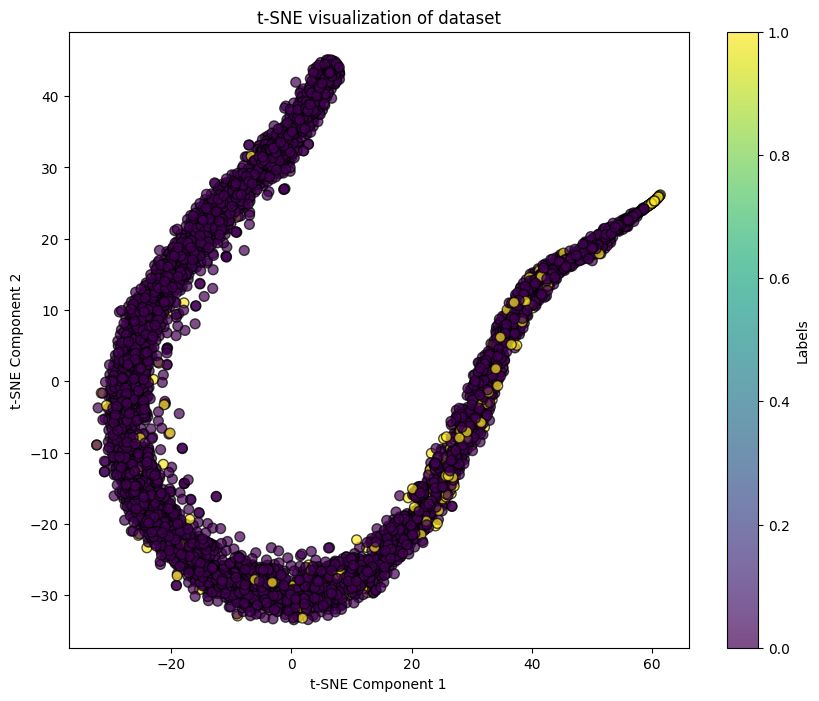

In [67]:
from sklearn.manifold import TSNE
# Create a t-SNE instance and fit_transform the data
tsne = TSNE(n_components=2, random_state=42, perplexity=100, n_iter=3000)
X_tsne = tsne.fit_transform(X)
print(tsne.kl_divergence_)

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=y,cmap='viridis', alpha=0.7, edgecolors='k', s=50)

# Add legend and title
plt.title('t-SNE visualization of dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Labels')

plt.show()

In [69]:
dataset_anom_lof=data[data.Anomaly_lof==1]
dataset_normal_lof=data[data.Anomaly_lof==0]
dataset_anom_scale_lof=scaled_data_level1[scaled_data_level1.Anomaly_lof==1]
dataset_normal_scale_lof=scaled_data_level1[scaled_data_level1.Anomaly_lof==0]

In [70]:
dataset_anom_lof

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8902,V8903,V8904,V8905,V8909,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof
0,17.979467,7.637658,16.376963,9.065730,26.738214,2.008903,7.502881,48.748408,39.922607,76.595472,...,71.994451,68.992087,109.847287,87.933166,68.997616,PRV57172,-1,-0.311252,1,0.046617
2,16.413701,7.264339,14.450170,8.178231,23.513926,1.875580,6.684496,24.926139,34.287838,68.593311,...,65.092621,62.474321,88.263680,68.040237,61.502494,PRV54966,-1,-0.296244,1,0.044315
7,5.514852,2.250923,5.519159,2.976793,8.391648,0.620984,2.466040,8.497639,11.344784,23.081418,...,22.167160,21.152602,29.813710,22.085972,20.598040,PRV55064,-1,-0.108895,1,0.035939
8,0.399918,0.182354,0.374670,0.212492,0.796410,0.038428,0.189940,0.712473,1.023636,1.891781,...,1.870363,1.755446,2.481940,1.862349,1.772786,PRV55104,1,0.126780,1,0.034972
11,0.560439,0.231664,0.573797,0.315417,0.815618,0.062756,0.247837,0.907779,1.325942,2.495976,...,2.451536,2.400798,3.345020,2.636224,2.408500,PRV56257,1,0.108668,1,0.035039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4302,0.095248,0.049115,0.091549,0.051760,0.118582,0.015113,0.036511,0.099120,0.216571,0.414415,...,0.422455,0.382110,0.519156,0.460441,0.367898,PRV52993,1,0.133354,1,0.035092
4486,0.399678,0.142137,0.382949,0.216966,0.634408,0.038313,0.175702,0.529641,0.947399,1.695721,...,1.776437,1.679549,2.392193,2.019182,1.660949,PRV52350,1,0.125187,1,0.034960
4513,0.127662,0.050098,0.187117,0.071776,0.203334,0.018432,0.049624,0.164476,0.286248,0.541135,...,0.587170,0.564388,0.752009,0.569900,0.520858,PRV54288,1,0.131273,1,0.034907
4698,0.032975,0.021925,0.017275,0.012162,0.078668,0.001578,0.042160,0.081458,0.112386,0.228360,...,0.153545,0.156765,0.237699,0.178426,0.150613,PRV53642,1,0.126100,1,0.035237


In [71]:
from sklearn.metrics import silhouette_score
clusters=scaled_data_level1['Anomaly_lof'].values
score = silhouette_score(scaled_data_level1, clusters)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.7106844422684034


In [72]:
Lof_model_pickled=util.pickle_dump(model,config_data['Lof_model'])

#SHAP

In [73]:
dataset_anom_lof

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8902,V8903,V8904,V8905,V8909,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof
0,17.979467,7.637658,16.376963,9.065730,26.738214,2.008903,7.502881,48.748408,39.922607,76.595472,...,71.994451,68.992087,109.847287,87.933166,68.997616,PRV57172,-1,-0.311252,1,0.046617
2,16.413701,7.264339,14.450170,8.178231,23.513926,1.875580,6.684496,24.926139,34.287838,68.593311,...,65.092621,62.474321,88.263680,68.040237,61.502494,PRV54966,-1,-0.296244,1,0.044315
7,5.514852,2.250923,5.519159,2.976793,8.391648,0.620984,2.466040,8.497639,11.344784,23.081418,...,22.167160,21.152602,29.813710,22.085972,20.598040,PRV55064,-1,-0.108895,1,0.035939
8,0.399918,0.182354,0.374670,0.212492,0.796410,0.038428,0.189940,0.712473,1.023636,1.891781,...,1.870363,1.755446,2.481940,1.862349,1.772786,PRV55104,1,0.126780,1,0.034972
11,0.560439,0.231664,0.573797,0.315417,0.815618,0.062756,0.247837,0.907779,1.325942,2.495976,...,2.451536,2.400798,3.345020,2.636224,2.408500,PRV56257,1,0.108668,1,0.035039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4302,0.095248,0.049115,0.091549,0.051760,0.118582,0.015113,0.036511,0.099120,0.216571,0.414415,...,0.422455,0.382110,0.519156,0.460441,0.367898,PRV52993,1,0.133354,1,0.035092
4486,0.399678,0.142137,0.382949,0.216966,0.634408,0.038313,0.175702,0.529641,0.947399,1.695721,...,1.776437,1.679549,2.392193,2.019182,1.660949,PRV52350,1,0.125187,1,0.034960
4513,0.127662,0.050098,0.187117,0.071776,0.203334,0.018432,0.049624,0.164476,0.286248,0.541135,...,0.587170,0.564388,0.752009,0.569900,0.520858,PRV54288,1,0.131273,1,0.034907
4698,0.032975,0.021925,0.017275,0.012162,0.078668,0.001578,0.042160,0.081458,0.112386,0.228360,...,0.153545,0.156765,0.237699,0.178426,0.150613,PRV53642,1,0.126100,1,0.035237


In [74]:
dataset_anom_lof

,0010,0011,0019,0020,0021,0022,0023,0029,0030,0031,...,V8902,V8903,V8904,V8905,V8909,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof
0,17.979467,7.637658,16.376963,9.065730,26.738214,2.008903,7.502881,48.748408,39.922607,76.595472,...,71.994451,68.992087,109.847287,87.933166,68.997616,PRV57172,-1,-0.311252,1,0.046617
2,16.413701,7.264339,14.450170,8.178231,23.513926,1.875580,6.684496,24.926139,34.287838,68.593311,...,65.092621,62.474321,88.263680,68.040237,61.502494,PRV54966,-1,-0.296244,1,0.044315
7,5.514852,2.250923,5.519159,2.976793,8.391648,0.620984,2.466040,8.497639,11.344784,23.081418,...,22.167160,21.152602,29.813710,22.085972,20.598040,PRV55064,-1,-0.108895,1,0.035939
8,0.399918,0.182354,0.374670,0.212492,0.796410,0.038428,0.189940,0.712473,1.023636,1.891781,...,1.870363,1.755446,2.481940,1.862349,1.772786,PRV55104,1,0.126780,1,0.034972
11,0.560439,0.231664,0.573797,0.315417,0.815618,0.062756,0.247837,0.907779,1.325942,2.495976,...,2.451536,2.400798,3.345020,2.636224,2.408500,PRV56257,1,0.108668,1,0.035039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4302,0.095248,0.049115,0.091549,0.051760,0.118582,0.015113,0.036511,0.099120,0.216571,0.414415,...,0.422455,0.382110,0.519156,0.460441,0.367898,PRV52993,1,0.133354,1,0.035092
4486,0.399678,0.142137,0.382949,0.216966,0.634408,0.038313,0.175702,0.529641,0.947399,1.695721,...,1.776437,1.679549,2.392193,2.019182,1.660949,PRV52350,1,0.125187,1,0.034960
4513,0.127662,0.050098,0.187117,0.071776,0.203334,0.018432,0.049624,0.164476,0.286248,0.541135,...,0.587170,0.564388,0.752009,0.569900,0.520858,PRV54288,1,0.131273,1,0.034907
4698,0.032975,0.021925,0.017275,0.012162,0.078668,0.001578,0.042160,0.081458,0.112386,0.228360,...,0.153545,0.156765,0.237699,0.178426,0.150613,PRV53642,1,0.126100,1,0.035237


In [663]:
scaled_data_level1

Value,79678,71656,64881,36401,2948,31400,42490,11590,72089,4271,...,E8259,90241,0828,E8262,E9192,86131,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof
0,21.098823,25.245726,19.018620,18.195982,15.035871,17.837344,21.918646,0.0,0.0,20.007845,...,21.277258,22.031412,20.637458,21.042516,20.133751,20.869877,1,-0.269627,0,-11.480396
1,8.197379,4.916840,8.448585,8.185605,9.422183,16.864376,7.770128,0.0,0.0,6.936071,...,8.522722,7.933402,8.558158,8.066862,7.809594,8.240484,1,-0.132074,0,-11.768354
2,15.767251,19.730992,17.260887,19.530818,16.301224,14.676554,26.943386,0.0,0.0,17.397064,...,18.406160,18.648452,18.382488,19.037224,18.577607,18.817840,1,-0.254555,0,-11.819957
3,0.728286,2.150928,0.294145,1.072423,0.636691,1.354512,0.552648,0.0,0.0,0.929285,...,0.681295,0.641167,0.448779,0.709064,0.817821,0.551270,0,0.078883,0,-14.042298
4,2.246299,1.476713,1.694906,1.956349,1.494629,1.150731,2.963977,0.0,0.0,2.307804,...,2.181049,2.136355,2.190115,2.213382,2.035643,2.256091,0,0.010988,0,-7.252400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,-0.385003,-0.290586,-0.156027,-0.344887,-0.297596,-0.243260,-0.332131,0.0,0.0,-0.376644,...,-0.375574,-0.385558,-0.330989,-0.371058,-0.380216,-0.379987,0,0.157267,0,-0.999884
5406,-0.334925,-0.244242,-0.230844,-0.344887,-0.317784,-0.243260,-0.332131,0.0,0.0,-0.325190,...,-0.387858,-0.359552,-0.355804,-0.355516,-0.356337,-0.390477,0,0.156490,0,-0.999881
5407,-0.364738,-0.073826,-0.314212,-0.344887,-0.273789,-0.243260,-0.005701,0.0,0.0,-0.307551,...,-0.333845,-0.346962,-0.349256,-0.339582,-0.286652,-0.329909,0,0.159649,0,-0.999701
5408,-0.385003,-0.318912,-0.375398,-0.344887,-0.335128,-0.243260,-0.332131,0.0,0.0,-0.364763,...,-0.401561,-0.406693,-0.404434,-0.390894,-0.390634,-0.406311,0,0.135634,0,-1.000107


In [69]:
dataset_anom_lof['Anomaly_score_lof'].max()

-6.977288871097926

In [665]:
dataset_anom_lof

Value,79678,71656,64881,36401,2948,31400,42490,11590,72089,4271,...,90241,0828,E8262,E9192,86131,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof
5,3.899041,2.328778,6.053900,1.290294,9.975347,0.257211,1.091387,0.0,0.0,9.258543,...,10.029273,8.936831,13.969258,9.317507,9.059440,PRV54683,0,-0.054604,1,-19.004368
7,4.904395,1.952616,6.073710,1.286010,11.479384,0.595464,2.662568,0.0,0.0,15.064718,...,11.979538,11.154956,18.186468,12.662518,11.670976,PRV55064,0,-0.098299,1,-16.554969
8,0.295550,0.272146,0.517756,0.066337,0.341070,0.054777,0.141284,0.0,0.0,1.095575,...,1.335193,0.837065,1.553207,1.247614,1.131278,PRV55104,0,0.132064,1,-31.842524
16,34.506963,24.998880,50.550847,13.132154,92.231697,4.517960,17.655039,0.0,0.0,122.990503,...,95.492021,89.748172,145.035290,102.623979,98.465711,PRV53797,1,-0.316020,1,-18.194473
21,61.058274,37.187143,84.491736,25.104484,167.993135,5.828019,29.207219,0.0,0.0,225.187901,...,165.011725,154.758205,250.221306,175.360189,167.170799,PRV51459,1,-0.320631,1,-33.526670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4768,0.092570,0.067378,0.050194,0.069575,0.160321,0.000592,0.008591,0.0,0.0,0.551222,...,0.193094,0.190199,0.375975,0.351029,0.184594,PRV54301,0,0.165058,1,-26.417641
4777,0.065836,0.000497,0.044636,0.039738,0.161801,0.000489,0.002782,0.0,0.0,0.268259,...,0.184978,0.163260,0.400735,0.161653,0.201378,PRV57552,0,0.157903,1,-19.007388
4811,0.022559,0.001519,0.001510,0.001523,0.005857,0.000000,0.001464,0.0,0.0,0.065210,...,0.058371,0.072538,0.095343,0.035356,0.028009,PRV55564,0,0.154886,1,-19.036313
5084,0.118805,0.029141,0.438830,0.016065,0.391704,0.021059,0.094736,0.0,0.0,0.388744,...,0.541498,0.630851,0.760412,0.413384,0.540953,PRV53214,0,0.160720,1,-18.399691


100%|===================| 540/541 [00:19<00:00]        

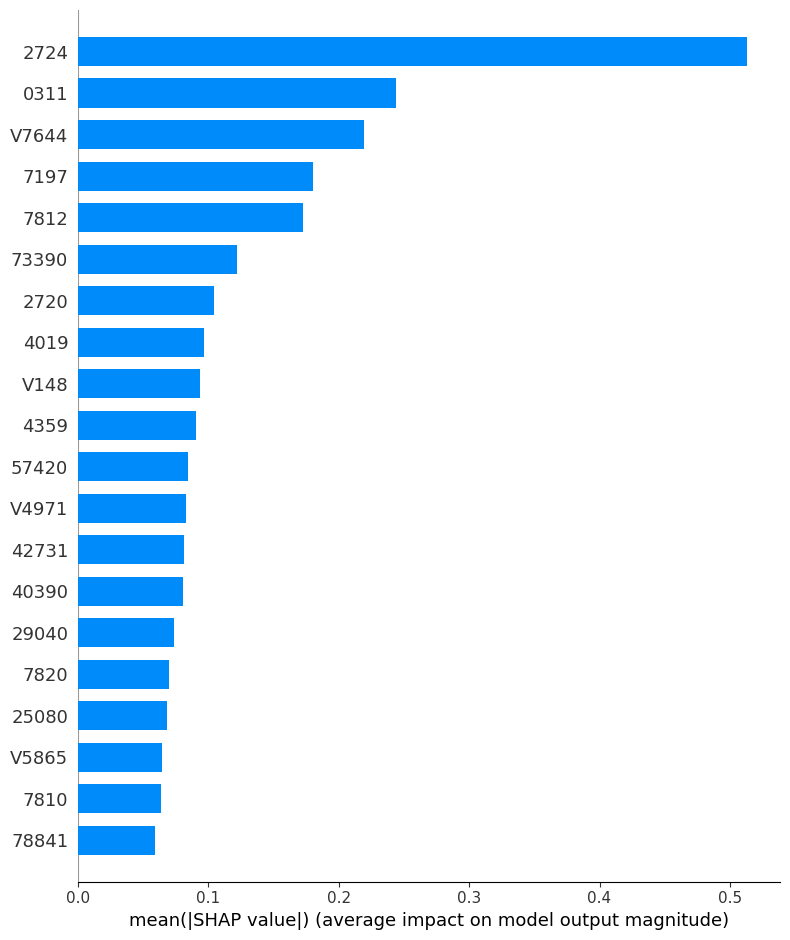

In [133]:
from sklearn.ensemble import RandomForestRegressor
import shap
lof_scores = dataset_anom_lof['Anomaly_score_lof'].values # Invert for easier interpretation


# Fit a Random Forest model on the LOF scores
rf_model = RandomForestRegressor()
rf_model.fit(dataset_anom_lof.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof']), lof_scores)

# Use SHAP to explain the Random Forest model
explainer = shap.TreeExplainer(rf_model, dataset_anom_lof.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof']))
shap_values_lof = explainer(dataset_anom_lof.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof']))

# Visualize SHAP values
shap.summary_plot(shap_values_lof, dataset_anom_lof.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof']),plot_type='bar')

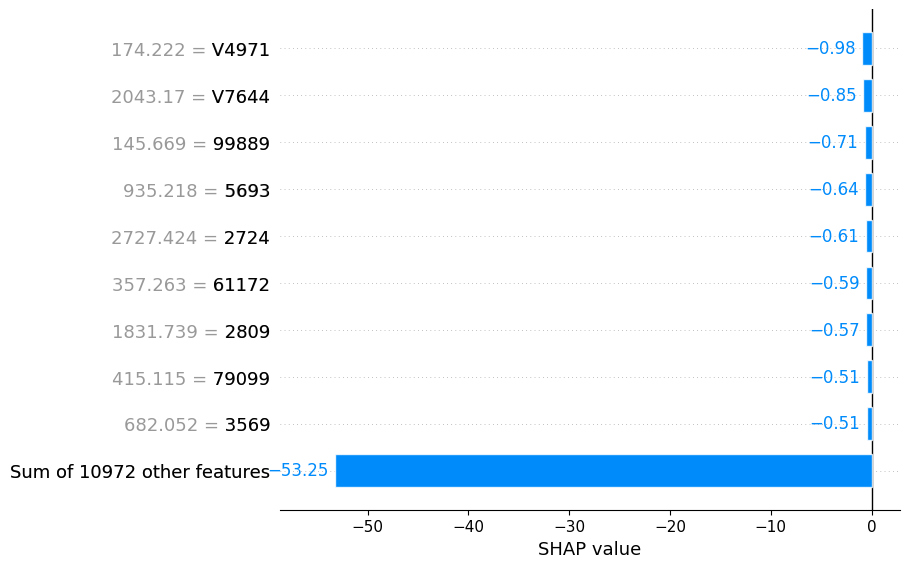

In [134]:
shap.plots.bar(shap_values_lof[8])

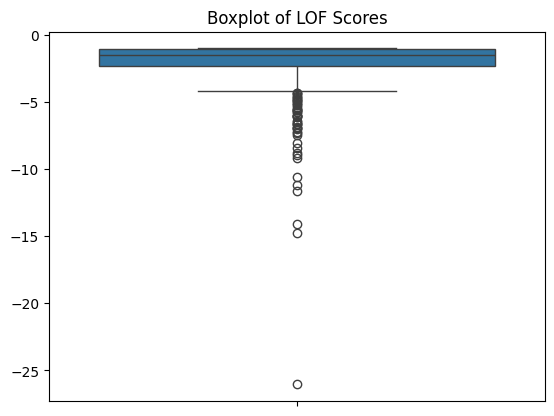

In [165]:
import seaborn as sns

sns.boxplot(y=lof_scores)
plt.title('Boxplot of LOF Scores')
plt.show()

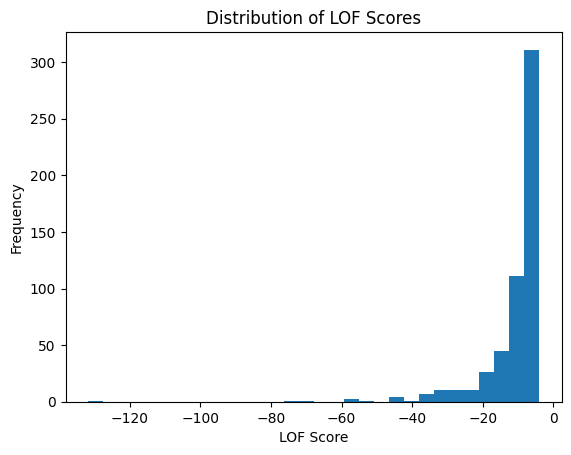

In [135]:
import matplotlib.pyplot as plt

plt.hist(lof_scores, bins=30)
plt.xlabel('LOF Score')
plt.ylabel('Frequency')
plt.title('Distribution of LOF Scores')
plt.show()

In [70]:
dataset_anom_rank_lof_sorted=dataset_anom_lof.sort_values(by='Anomaly_score_lof',ascending=False)

In [71]:
dataset_anom_rank_lof_sorted['Rank']=range(1,len(dataset_anom_rank_lof_sorted)+1)

In [72]:
dataset_anom_rank_lof_sorted

,0010,0011,0019,0020,0021,0022,0023,0024,0025,0029,...,V8903,V8904,V8905,V8909,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof,Rank
4334,0.228841,0.078147,0.131947,0.092868,1.275312,0.000489,0.160168,0.0,0.0,0.609912,...,0.680675,0.877069,0.626119,0.578923,PRV55140,0,0.155740,1,-82.647998,1
4524,0.000000,0.000000,0.000000,0.000000,0.101718,0.000000,0.000000,0.0,0.0,0.000000,...,0.026185,0.000000,0.000000,0.050830,PRV53572,0,0.144110,1,-68.596490,2
3751,0.040401,0.015277,0.035201,0.077715,0.133207,0.000000,0.017078,0.0,0.0,0.365747,...,0.323491,0.564467,0.309265,0.347541,PRV56184,0,0.158595,1,-64.677656,3
1661,0.492432,0.379940,0.275729,0.185375,0.728426,0.118368,0.095152,0.0,0.0,0.807595,...,1.189227,1.544851,1.021083,0.984790,PRV54250,0,0.131163,1,-52.262114,4
4533,0.063546,0.008090,0.003471,0.009150,0.144618,0.000370,0.003263,0.0,0.0,0.041543,...,0.080219,0.131422,0.083616,0.146584,PRV56524,0,0.164017,1,-39.501755,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,0.177775,0.029658,0.124768,0.013786,0.362046,0.046351,0.185574,0.0,0.0,1.264004,...,0.478953,0.449713,0.442707,0.395326,PRV53745,0,0.166660,1,-7.019254,537
4732,0.000000,0.000000,0.029829,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.037972,...,0.054011,0.058069,0.015653,0.015653,PRV53646,0,0.151778,1,-7.007875,538
632,0.297596,1.017715,0.232653,0.064057,0.450765,0.058556,0.189984,0.0,0.0,1.309505,...,0.618525,1.080186,0.957045,0.861091,PRV51229,0,0.138405,1,-6.989531,539
983,0.171558,0.046445,0.049664,0.015428,0.153399,0.000000,0.000000,0.0,0.0,1.267379,...,0.186674,0.330190,0.344438,0.326384,PRV55818,0,0.156368,1,-6.989044,540


In [73]:
data_lof_rank=util.pickle_dump(dataset_anom_rank_lof_sorted.drop(columns=['Anomaly_ind','Anomaly_score']),config_data['raw_dataset_path_lof_rank'])

#RRCF

In [75]:
import numpy as np
import pandas as pd
import rrcf

n=5410
# Set forest parameters
num_trees = 200
tree_size = 256
sample_size_range = (n // tree_size, tree_size)

# Construct forest
forest = []
while len(forest) < num_trees:
    # Select random subsets of points uniformly
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    # Add sampled trees to forest
    trees = [rrcf.RCTree(scaled_data_level1.iloc[ix].values, index_labels=ix)
             for ix in ixs]
    forest.extend(trees)

# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                       for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index
scaled_data_level1['Anomaly_score_rrcf'] =avg_codisp
data['Anomaly_score_rrcf']=avg_codisp



<Axes: >

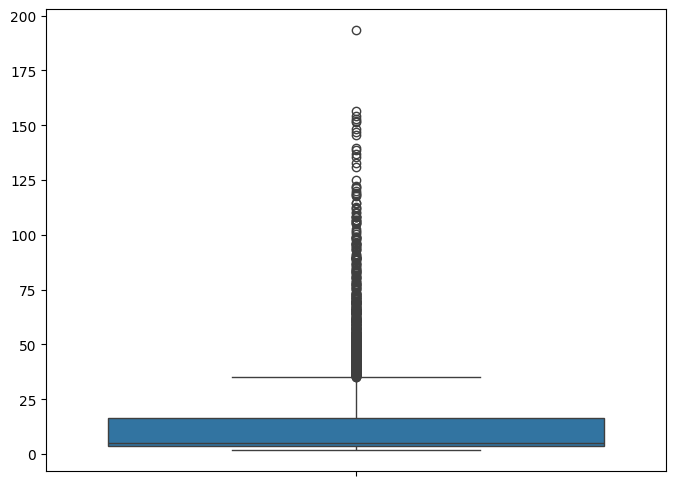

In [149]:
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.boxplot(data=avg_codisp)

In [76]:
scaled_data_level1['Anomaly_rrcf'] = scaled_data_level1['Anomaly_score_rrcf'].apply(lambda x: 1 if x >= avg_codisp.quantile(0.95) else 0)
data['Anomaly_rrcf'] = data['Anomaly_score_rrcf'].apply(lambda x: 1 if x >= avg_codisp.quantile(0.95) else 0)

In [556]:
X=scaled_data_level1.drop(columns='Anomaly_rrcf')
y=scaled_data_level1['Anomaly_rrcf']

/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


0.4476317763328552


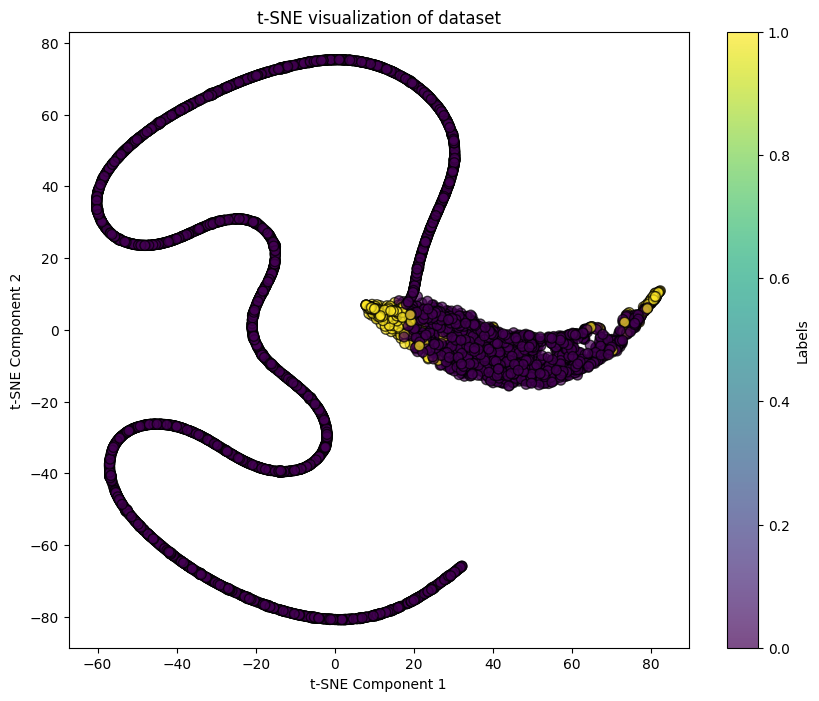

In [152]:
from sklearn.manifold import TSNE
# Create a t-SNE instance and fit_transform the data
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=3000)
X_tsne = tsne.fit_transform(X)
print(tsne.kl_divergence_)

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=y,cmap='viridis', alpha=0.7, edgecolors='k', s=50)

# Add legend and title
plt.title('t-SNE visualization of dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Labels')

plt.show()

In [77]:
dataset_anom_rrcf=data[data.Anomaly_rrcf==1]
dataset_normal_rrcf=data[data.Anomaly_rrcf==0]
dataset_anom_scale_rrcf=data[scaled_data_level1.Anomaly_rrcf==1]
dataset_normal_scale_rrcf=scaled_data_level1[scaled_data_level1.Anomaly_rrcf==0]

In [78]:
dataset_anom_rrcf.fillna(0,inplace=True)

/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_868/4115193019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_anom_rrcf.fillna(0,inplace=True)


In [79]:
dataset_anom_rrcf

,0010,0011,0019,0020,0021,0022,0023,0024,0025,0029,...,V8904,V8905,V8909,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof,Anomaly_score_rrcf,Anomaly_rrcf
0,14.533874,11.494257,20.538600,4.893868,35.119895,1.583433,6.982981,0.0,0.0,52.024414,...,61.859534,42.697074,41.447166,PRV57172,1,-0.267412,0,-1.685406,56.449437,1
1,5.806008,2.354075,9.344750,2.251626,22.293655,1.498224,2.542739,0.0,0.0,18.675904,...,24.422940,17.072647,16.844425,PRV55158,1,-0.123168,0,-3.592144,45.806522,1
2,10.927049,9.014747,18.677131,5.246199,38.010992,1.306623,8.559899,0.0,0.0,45.363829,...,56.073983,39.461534,37.449686,PRV54966,1,-0.256096,0,-1.998526,73.312932,1
6,6.572575,4.888810,10.187292,2.021855,27.640012,1.440816,4.408498,0.0,0.0,22.630778,...,27.665911,20.647681,18.603709,PRV54986,1,-0.154262,0,-3.352799,47.769971,1
8,0.295550,0.272146,0.517756,0.066337,0.341070,0.054777,0.141284,0.0,0.0,1.095575,...,1.553207,1.247614,1.131278,PRV55104,0,0.140450,0,-2.309867,85.616667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4870,0.054412,0.010641,0.044689,0.002380,0.080623,0.000000,0.001157,0.0,0.0,0.141398,...,0.248037,0.186009,0.105734,PRV55398,0,0.171486,0,-0.999039,55.901632,1
5138,0.000000,0.009316,0.000000,0.000000,0.008582,0.008969,0.000000,0.0,0.0,0.000000,...,0.022392,0.007092,0.007092,PRV56920,0,0.148812,1,-30.982224,82.111111,1
5156,0.057819,0.043082,0.068981,0.010417,0.175775,0.000488,0.050311,0.0,0.0,1.157938,...,0.393335,0.315779,0.302274,PRV54204,0,0.165024,0,-4.401825,52.304167,1
5174,0.151950,0.032043,0.158848,0.007282,0.065743,0.030866,0.009777,0.0,0.0,0.306797,...,0.458483,0.371703,0.335433,PRV55815,0,0.168161,1,-7.511969,56.666667,1


In [80]:
rrcf_model_pickled=util.pickle_dump(model,config_data['rrcf_model'])

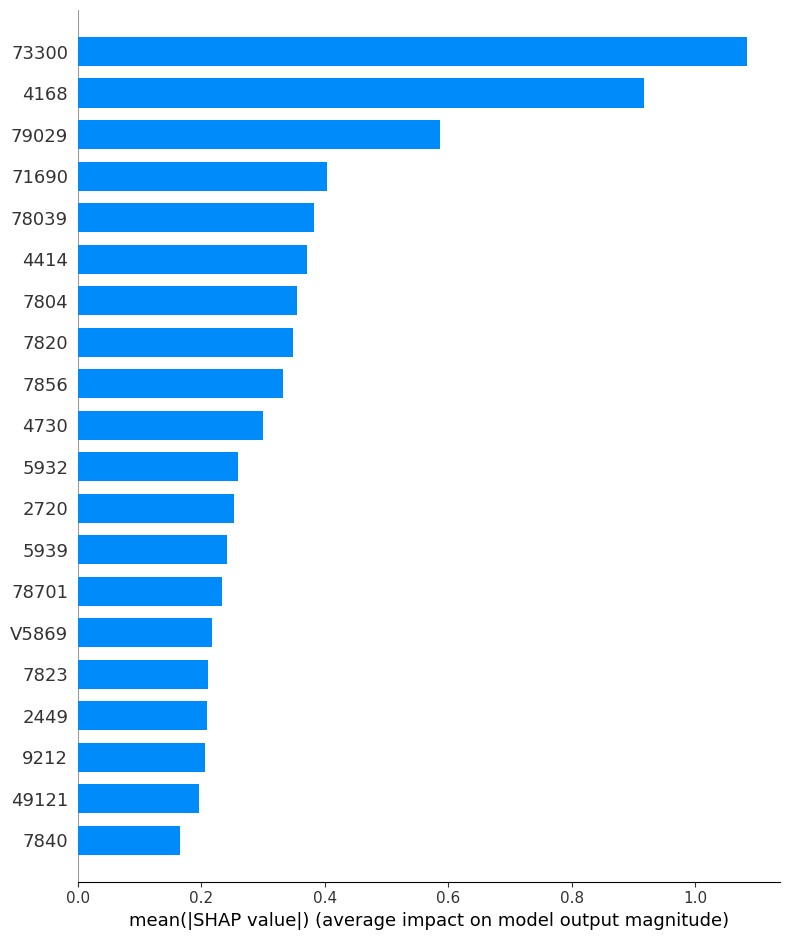

In [156]:
from sklearn.ensemble import RandomForestRegressor
rrcf_scores = dataset_anom_rrcf['Anomaly_score_rrcf'].values # Invert for easier interpretation


# Fit a Random Forest model on the LOF scores
rf_model = RandomForestRegressor()
rf_model.fit(dataset_anom_rrcf.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof','Anomaly_rrcf','Anomaly_score_rrcf']), rrcf_scores)

# Use SHAP to explain the Random Forest model
explainer = shap.Explainer(rf_model, dataset_anom_rrcf.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof','Anomaly_rrcf','Anomaly_score_rrcf']))
shap_values_rrcf = explainer(dataset_anom_rrcf.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof','Anomaly_rrcf','Anomaly_score_rrcf']))


# Visualize SHAP values
shap.summary_plot(shap_values_rrcf, dataset_anom_rrcf.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof','Anomaly_rrcf','Anomaly_score_rrcf']),plot_type='bar')

In [81]:
dataset_anom_rank_rrcf_sorted=dataset_anom_rrcf.sort_values(by='Anomaly_score_rrcf',ascending=False)

In [82]:
dataset_anom_rank_rrcf_sorted['Rank']=range(1,len(dataset_anom_rank_rrcf_sorted)+1)

In [83]:
dataset_anom_rank_rrcf_sorted

,0010,0011,0019,0020,0021,0022,0023,0024,0025,0029,...,V8905,V8909,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof,Anomaly_score_rrcf,Anomaly_rrcf,Rank
21,61.058274,37.187143,84.491736,25.104484,167.993135,5.828019,29.207219,0.0,0.0,225.187901,...,175.360189,167.170799,PRV51459,1,-0.325882,0,-5.335298,188.440000,1,1
16,34.506963,24.998880,50.550847,13.132154,92.231697,4.517960,17.655039,0.0,0.0,122.990503,...,102.623979,98.465711,PRV53797,1,-0.321816,0,-2.662204,158.827273,1,2
704,22.633744,16.535015,36.445557,10.087109,71.734630,3.578706,12.913228,0.0,0.0,92.401643,...,75.572791,71.732563,PRV54895,1,-0.312594,0,-2.383050,151.025758,1,3
352,23.327086,21.321944,37.675518,9.630045,72.227696,2.600531,11.203357,0.0,0.0,97.060447,...,76.998852,72.911645,PRV53918,1,-0.308591,0,-2.711027,137.280606,1,4
385,15.770688,9.722714,21.747217,5.697808,39.704386,1.543573,7.176027,0.0,0.0,50.097869,...,44.991444,43.221235,PRV52628,1,-0.276142,0,-1.771674,134.251667,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,5.806008,2.354075,9.344750,2.251626,22.293655,1.498224,2.542739,0.0,0.0,18.675904,...,17.072647,16.844425,PRV55158,1,-0.123168,0,-3.592144,45.806522,1,267
1460,0.104547,0.137531,0.607744,0.154001,0.622119,0.008081,0.135861,0.0,0.0,0.398901,...,0.394233,0.489485,PRV53274,0,0.157982,0,-2.011606,45.788333,1,268
3544,0.053661,0.015245,0.129785,0.086610,0.232128,0.035116,0.019542,0.0,0.0,0.494221,...,0.303457,0.303243,PRV51886,0,0.162417,1,-13.068003,45.683333,1,269
1253,0.698964,0.386395,1.725487,0.548851,2.817200,0.124728,0.228520,0.0,0.0,2.130017,...,2.364373,2.182110,PRV52166,0,0.091797,0,-1.803878,45.460522,1,270


In [84]:
data_rrcf_rank=util.pickle_dump(dataset_anom_rank_rrcf_sorted.drop(columns=['Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof'],axis=1),config_data['raw_dataset_path_rrcf_rank'])